In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from mlforecast import MLForecast
from mlforecast.target_transforms import Differences

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import lightgbm as lgb
import xgboost  as xgb


In [65]:
pdf = pd.read_csv("../../data/daily/ewz_stromabgabe_netzebenen_stadt_zuerich.csv",index_col=None)
pdf.index = pd.to_datetime(pdf['Timestamp'],utc=True)
pdf.index = pdf.index.tz_localize(None)  

pdf["ds"] = pdf.index
pdf["unique_id"] = "test"
pdf = pdf.reset_index(drop=True)

pdf["y"] = (pdf["NE5_GWh"].values + pdf["NE7_GWh"].values)
pdf = pdf.drop(columns=["Timestamp","NE5_GWh","NE7_GWh"])

split = len(pdf)-365
pdf_train, pdf_test = pdf.iloc[:split], pdf.iloc[split:]

pdf

Reassigned 1 values in the column Value_NE5. These values where more than 3 sigma away from the mean.
Reassigned 1 values in the column Value_NE7. These values where more than 3 sigma away from the mean.


C:\Users\ewzbusi\AppData\Local\Temp\ipykernel_13680\3593820342.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pdf = pdf.resample(frequency).sum(min_count=1) #"D,W,M"


ds unique_id         y
0    2015-01-01      test  6.709087
1    2015-01-02      test  7.073348
2    2015-01-03      test  7.149544
3    2015-01-04      test  6.724467
4    2015-01-05      test  8.585045
...         ...       ...       ...
3102 2023-06-30      test  7.247760
3103 2023-07-01      test  6.168368
3104 2023-07-02      test  5.750607
3105 2023-07-03      test  7.029407
3106 2023-07-04      test  6.826165

[3107 rows x 3 columns]

In [66]:
models = [
    LinearRegression(),
    lgb.LGBMRegressor(),
    RandomForestRegressor(random_state=0),
]

#    xgb.XGBRegressor()

mlf = MLForecast(
    models = models,
    lags=[7, 365],
    freq = 'D', 
    date_features=['dayofweek'],
    target_transforms=[Differences([365])]
)
#
mlf.fit(pdf_train)


MLForecast(models=[LinearRegression, LGBMRegressor, RandomForestRegressor], freq=<Day>, lag_features=['lag7', 'lag365'], date_features=['dayofweek'], num_threads=1)

In [67]:
y_pred = mlf.predict(int(len(pdf_test)))

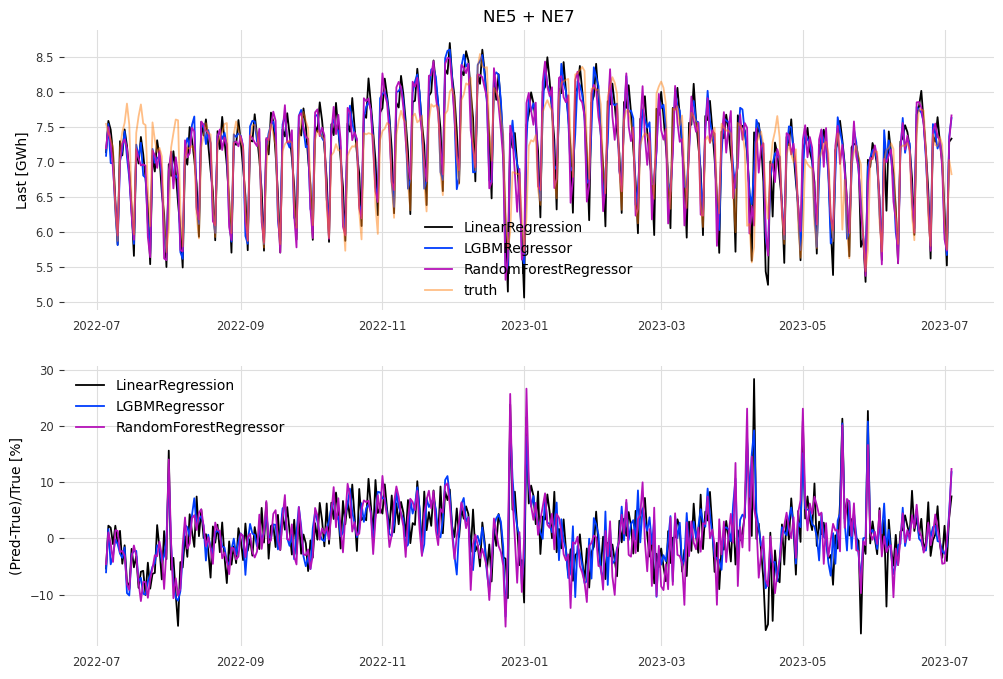

In [68]:
f, axes = plt.subplots(2, 1, figsize=(12, 8))

for name in y_pred.columns[2:]:
    axes[0].plot(y_pred.ds.values, y_pred[name],label=f"{name}")

# axes[0].plot(pdfTrain.ds.values, pdfTrain.y.values, color="tab:blue", label="train")
axes[0].plot(pdf_test.ds.values, pdf_test.y.values, color="tab:orange", label="truth", alpha=0.5)
axes[0].legend()
axes[0].set_title("NE5 + NE7")
axes[0].set_ylabel("Last [GWh]")


xmin, xmax = axes[0].get_xlim()

for name in y_pred.columns[2:]:
    axes[1].plot(pdf_test.ds, ((y_pred[name] - pdf_test.y.values) / (pdf_test.y.values))*100,label=f"{name}")
axes[1].set_xlim(xmin, xmax)
axes[1].set_ylabel("(Pred-True)/True [%]")
axes[1].legend()


plt.show()



In [69]:
for name in y_pred.columns[2:]:
    print(f"RMSE {name}:"+ "{:.3f}".format(mean_squared_error(pdf_test.y.values, y_pred[name].values, squared=False)))

RMSE LinearRegression:0.393
RMSE LGBMRegressor:0.364
RMSE RandomForestRegressor:0.398


In [70]:
# RMSE LinearRegression:0.396
# RMSE LGBMRegressor:0.394
# RMSE XGBRegressor:0.413
# RMSE RandomForestRegressor:0.400

In [ ]:
# n_estimators = number of trees in the foreset
# max_features = max number of features considered for splitting a node
# max_depth = max number of levels in each decision tree
# min_samples_split = min number of data points placed in a node before the node is split
# min_samples_leaf = min number of data points allowed in a leaf node
# bootstrap = method for sampling data points (with or without replacement)

# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# max_features = ['auto', 'sqrt']
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# min_samples_split = [2, 5, 10]
# min_samples_leaf = [1, 2, 4]
# bootstrap = [True, False]


#Databricks Hyperopt for random forest regressor
# space = {
#   "bootstrap": False,
#   "criterion": "mse",
#   "max_depth": 7,
#   "max_features": 0.8884610252801486,
#   "min_samples_leaf": 0.2710194671582393,
#   "min_samples_split": 0.49486252248140356,
#   "n_estimators": 5
# }

#Databricks Hyperopt for LightGBMRegressor
# space = {
#   "colsample_bytree": 0.6550176333919349,
#   "lambda_l1": 4.497336243090801,
#   "lambda_l2": 100.24793946360381,
#   "learning_rate": 0.27101173872864337,
#   "max_bin": 49,
#   "max_depth": 2,
#   "min_child_samples": 25,
#   "n_estimators": 944,
#   "num_leaves": 594,
#   "subsample": 0.7557808012458922,
# }


#Databricks Hyperopt for XGBoostRegressor
# space = {
#   "colsample_bytree": 0.5877837175644708,
#   "learning_rate": 0.14101276775729682,
#   "max_depth": 3,
#   "min_child_weight": 7,
#   "n_estimators": 583,
#   "subsample": 0.21452196547179753,
#   "verbosity": 0,
# }